In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.utils.data
import torch.nn as nn
from sklearn.preprocessing import Normalizer
from sklearn.metrics import mean_squared_error
import os
from sampler import ImbalancedDatasetSampler

In [28]:
fileNames = os.listdir('../Data')
newFileNames = []
outputFileNames = os.listdir('OriVectUsers/')

for name in fileNames:
    if 'User' in name:
        newFileNames.append(name)
        
newFileNames.sort()
outputFileNames.sort()

test_X_fName = newFileNames.pop(len(newFileNames)-1)

test_y_fName = outputFileNames.pop(len(outputFileNames)-1)

In [29]:
def centAndScale(magData):

    x = [float(row[0]) for row in magData]
    y = [float(row[1]) for row in magData]
    z = [float(row[2]) for row in magData]

    plt.scatter(x, y, label='XY')
    plt.scatter(x, z, label='XZ')
    plt.scatter(y, z, label='YZ')

    plt.xlabel('x label')
    plt.ylabel('y label')

    plt.show()

    offset_x = (max(x) + min(x)) / 2
    offset_y = (max(y) + min(y)) / 2
    offset_z = (max(z) + min(z)) / 2

    corrected_mag_data = np.array([[0, 0, 0]])

    for row in magData:

        corrected_x = float(row[0]) - offset_x
        corrected_y = float(row[1]) - offset_y
        corrected_z = float(row[2]) - offset_z

        corr_list = np.array([corrected_x, corrected_y, corrected_z])
        corr_list = corr_list.reshape((1, 3))

        corrected_mag_data = np.append(corrected_mag_data, corr_list, axis=0)

    corrected_mag_data = corrected_mag_data[1:]

    plt.scatter(corrected_mag_data[:, 0], corrected_mag_data[:, 1], label='XY')
    plt.scatter(corrected_mag_data[:, 0], corrected_mag_data[:, 2], label='XZ')
    plt.scatter(corrected_mag_data[:, 1], corrected_mag_data[:, 2], label='YZ')

    plt.xlabel('x label')
    plt.ylabel('y label')

    plt.show()

    norm_corr_mag_data = Normalizer().fit_transform(corrected_mag_data)

    return norm_corr_mag_data

In [30]:
def parseSheet(userSheetName, outputSheetName, test=False):
    
    user = pd.read_csv(userSheetName)
    userOutput = pd.read_excel(outputSheetName, header=None)

    user.drop(user.columns[[3, 4, 5, 6, 7, 8, 12, 13, 14, 15, 16]], axis=1, inplace=True)

    cols = user.columns.tolist()

    userAcc = np.asarray(user[['ACCELEROMETER X (m/s²)', 'ACCELEROMETER Y (m/s²)', 'ACCELEROMETER Z (m/s²)']].values)
    userMag = np.asarray(user[['MAGNETIC FIELD X (μT)', 'MAGNETIC FIELD Y (μT)', 'MAGNETIC FIELD Z (μT)']].values)
    
    userMag = centAndScale(userMag)
    
    userTensor = np.concatenate((userAcc, userMag), axis=1)
    
    userTensorOut = userOutput.values
    X = torch.as_tensor(userTensor).float()
    y = torch.as_tensor(userTensorOut).float()

    train = torch.utils.data.TensorDataset(X, y)
    
    return (train, X, y)

In [69]:
class RNN(nn.Module):

    def __init__(self, input_size, hidden_size, layer_size, output_size):

        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        self.layer_size = layer_size

        # self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        # self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.rnn = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=layer_size, batch_first=True)

        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, X):

        hidden = self.init_hidden(X)

        out, hidden = self.rnn(X, hidden)

        out = self.fc(out[:, -1, :])
        return out

    def init_hidden(self, X):

        return torch.zeros(self.layer_size, X.shape[0], self.hidden_size).float()

In [68]:
input_dim = 6
hidden_dim = 6
layer_dim = 1
output_dim = 6

rnn = RNN(input_dim, hidden_dim, layer_dim, output_dim)

error = nn.MSELoss()

learning_rate = 0.01

optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

count = 0

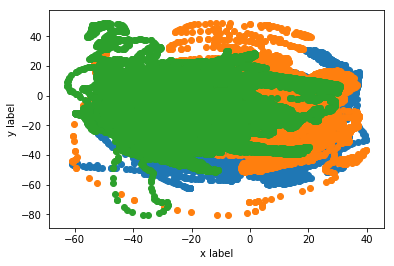

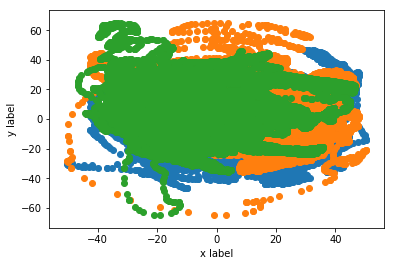

51
Output: tensor([ 1.0630, -0.6202,  0.0307,  0.0438,  0.4495,  0.9135],
       grad_fn=<SelectBackward>)
True: tensor([ 0.8462, -0.5329, -0.0026,  0.1491,  0.2321,  0.9612])
Loss: 0.030869673937559128

Output: tensor([ 1.0406, -0.5943,  0.0155,  0.0305,  0.4480,  0.9228],
       grad_fn=<SelectBackward>)
True: tensor([ 0.8462, -0.5329, -0.0026,  0.1491,  0.2321,  0.9612])
Loss: 0.02818342298269272

Output: tensor([ 1.0357, -0.5872,  0.0081,  0.0161,  0.4492,  0.9299],
       grad_fn=<SelectBackward>)
True: tensor([ 0.8462, -0.5329, -0.0026,  0.1491,  0.2321,  0.9612])
Loss: 0.02823604643344879

Output: tensor([ 1.0347, -0.5862,  0.0029,  0.0040,  0.4490,  0.9357],
       grad_fn=<SelectBackward>)
True: tensor([ 0.8462, -0.5329, -0.0026,  0.1491,  0.2321,  0.9612])
Loss: 0.0286452267318964

Output: tensor([ 1.0355, -0.5872, -0.0016, -0.0058,  0.4476,  0.9402],
       grad_fn=<SelectBackward>)
True: tensor([ 0.8462, -0.5329, -0.0026,  0.1491,  0.2321,  0.9612])
Loss: 0.0290576182305812

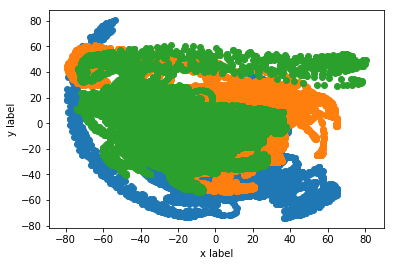

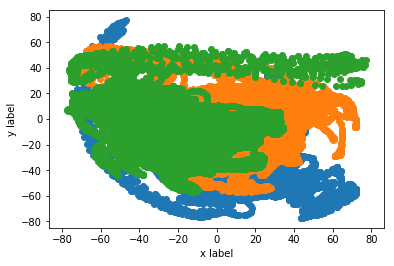

44
Output: tensor([-0.4939, -0.8918,  0.1751,  0.3300, -0.0287,  0.8231],
       grad_fn=<SelectBackward>)
True: tensor([-0.3735, -0.9269, -0.0363,  0.5291, -0.2450,  0.8124])
Loss: 0.024542782455682755

Output: tensor([-0.5128, -0.8876,  0.1641,  0.3571, -0.0296,  0.8226],
       grad_fn=<SelectBackward>)
True: tensor([-0.3735, -0.9269, -0.0363,  0.5291, -0.2450,  0.8124])
Loss: 0.023973489180207253

Output: tensor([-0.5195, -0.8835,  0.1594,  0.3682, -0.0283,  0.8238],
       grad_fn=<SelectBackward>)
True: tensor([-0.3735, -0.9269, -0.0363,  0.5291, -0.2450,  0.8124])
Loss: 0.024109307676553726

Output: tensor([-0.5209, -0.8785,  0.1568,  0.3711, -0.0264,  0.8274],
       grad_fn=<SelectBackward>)
True: tensor([-0.3735, -0.9269, -0.0363,  0.5291, -0.2450,  0.8124])
Loss: 0.024440376088023186

Output: tensor([-0.5200, -0.8735,  0.1550,  0.3708, -0.0246,  0.8319],
       grad_fn=<SelectBackward>)
True: tensor([-0.3735, -0.9269, -0.0363,  0.5291, -0.2450,  0.8124])
Loss: 0.024754915386

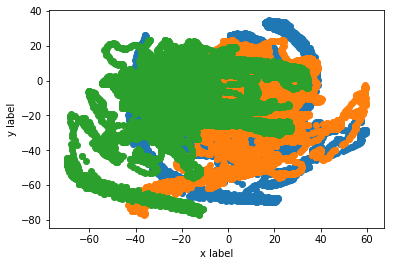

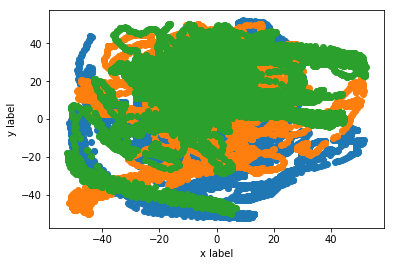

51
Output: tensor([ 0.7047,  0.4551,  0.0808, -0.2799, -0.0525,  0.9618],
       grad_fn=<SelectBackward>)
True: tensor([ 0.9009,  0.3223,  0.2907, -0.3639,  0.1956,  0.9107])
Loss: 0.08431464433670044

Output: tensor([ 0.6489,  0.3485,  0.0685, -0.2226, -0.0158,  0.9599],
       grad_fn=<SelectBackward>)
True: tensor([ 0.9009,  0.3223,  0.2907, -0.3639,  0.1956,  0.9107])
Loss: 0.07978399842977524

Output: tensor([ 0.6395,  0.3077,  0.0792, -0.1908,  0.0074,  0.9584],
       grad_fn=<SelectBackward>)
True: tensor([ 0.9009,  0.3223,  0.2907, -0.3639,  0.1956,  0.9107])
Loss: 0.07761330902576447

Output: tensor([ 0.6380,  0.2853,  0.0888, -0.1713,  0.0242,  0.9593],
       grad_fn=<SelectBackward>)
True: tensor([ 0.9009,  0.3223,  0.2907, -0.3639,  0.1956,  0.9107])
Loss: 0.07682278007268906

Output: tensor([ 0.6407,  0.2715,  0.0954, -0.1586,  0.0359,  0.9603],
       grad_fn=<SelectBackward>)
True: tensor([ 0.9009,  0.3223,  0.2907, -0.3639,  0.1956,  0.9107])
Loss: 0.0765106752514839

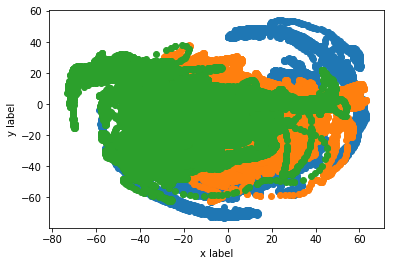

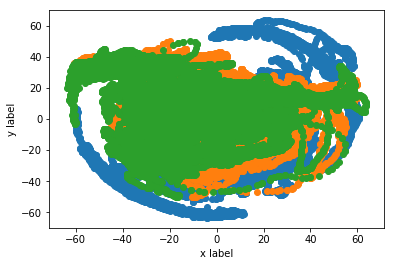

46
Output: tensor([-0.4807, -0.4243,  0.3089,  0.3566, -0.3624,  0.6896],
       grad_fn=<SelectBackward>)
True: tensor([-0.8322, -0.4069,  0.3767,  0.4946, -0.2376,  0.8360])
Loss: 0.04778014123439789

Output: tensor([-0.4955, -0.4721,  0.3056,  0.4105, -0.3218,  0.7238],
       grad_fn=<SelectBackward>)
True: tensor([-0.8322, -0.4069,  0.3767,  0.4946, -0.2376,  0.8360])
Loss: 0.03985033184289932

Output: tensor([-0.5003, -0.4940,  0.3286,  0.4258, -0.2975,  0.7511],
       grad_fn=<SelectBackward>)
True: tensor([-0.8322, -0.4069,  0.3767,  0.4946, -0.2376,  0.8360])
Loss: 0.03485877811908722

Output: tensor([-0.4989, -0.5073,  0.3541,  0.4293, -0.2834,  0.7661],
       grad_fn=<SelectBackward>)
True: tensor([-0.8322, -0.4069,  0.3767,  0.4946, -0.2376,  0.8360])
Loss: 0.0328969843685627

Output: tensor([-0.5005, -0.5142,  0.3751,  0.4315, -0.2741,  0.7725],
       grad_fn=<SelectBackward>)
True: tensor([-0.8322, -0.4069,  0.3767,  0.4946, -0.2376,  0.8360])
Loss: 0.03172991052269935

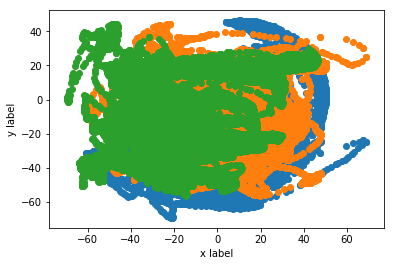

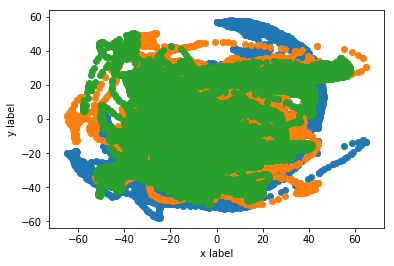

63
Output: tensor([ 0.1770,  0.7843, -0.1827, -0.4058,  0.1564,  0.9315],
       grad_fn=<SelectBackward>)
True: tensor([ 0.3074,  0.9226, -0.2331, -0.2904,  0.3242,  0.9003])
Loss: 0.01968190260231495

Output: tensor([ 0.1699,  0.7767, -0.1831, -0.3800,  0.1562,  0.9314],
       grad_fn=<SelectBackward>)
True: tensor([ 0.3074,  0.9226, -0.2331, -0.2904,  0.3242,  0.9003])
Loss: 0.020199617370963097

Output: tensor([ 0.1683,  0.7782, -0.1818, -0.3683,  0.1552,  0.9325],
       grad_fn=<SelectBackward>)
True: tensor([ 0.3074,  0.9226, -0.2331, -0.2904,  0.3242,  0.9003])
Loss: 0.02007121965289116

Output: tensor([ 0.1684,  0.7800, -0.1805, -0.3620,  0.1551,  0.9333],
       grad_fn=<SelectBackward>)
True: tensor([ 0.3074,  0.9226, -0.2331, -0.2904,  0.3242,  0.9003])
Loss: 0.019859299063682556

Output: tensor([ 0.1691,  0.7815, -0.1794, -0.3584,  0.1553,  0.9337],
       grad_fn=<SelectBackward>)
True: tensor([ 0.3074,  0.9226, -0.2331, -0.2904,  0.3242,  0.9003])
Loss: 0.01964747719466

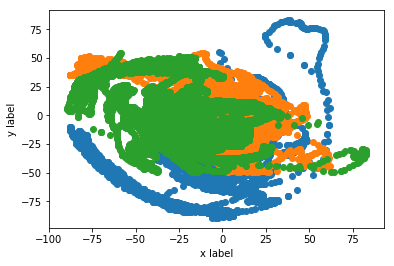

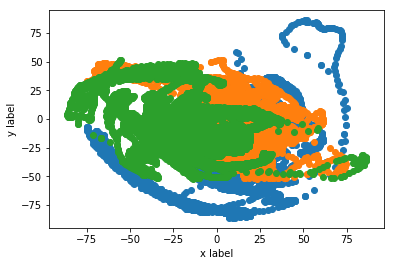

84
Output: tensor([-0.5342, -0.8494,  0.0653,  0.4432, -0.2234,  0.8493],
       grad_fn=<SelectBackward>)
True: tensor([-0.4891, -0.8722,  0.0122,  0.4370, -0.2329,  0.8688])
Loss: 0.002298325300216675

Output: tensor([-0.5492, -0.8358,  0.0836,  0.4348, -0.1995,  0.8484],
       grad_fn=<SelectBackward>)
True: tensor([-0.4891, -0.8722,  0.0122,  0.4370, -0.2329,  0.8688])
Loss: 0.003512018360197544

Output: tensor([-0.5573, -0.8309,  0.0934,  0.4305, -0.1862,  0.8493],
       grad_fn=<SelectBackward>)
True: tensor([-0.4891, -0.8722,  0.0122,  0.4370, -0.2329,  0.8688])
Loss: 0.004278357606381178

Output: tensor([-0.5621, -0.8286,  0.0999,  0.4282, -0.1793,  0.8499],
       grad_fn=<SelectBackward>)
True: tensor([-0.4891, -0.8722,  0.0122,  0.4370, -0.2329,  0.8688])
Loss: 0.004778272472321987

Output: tensor([-0.5652, -0.8274,  0.1043,  0.4269, -0.1759,  0.8499],
       grad_fn=<SelectBackward>)
True: tensor([-0.4891, -0.8722,  0.0122,  0.4370, -0.2329,  0.8688])
Loss: 0.005105238873

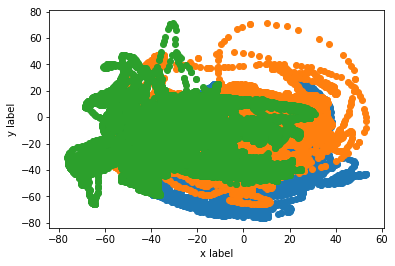

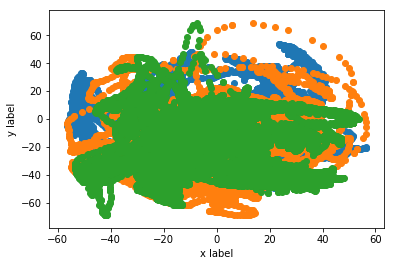

65
Output: tensor([ 0.5448,  0.5547,  0.5233, -0.3182, -0.1740,  0.7326],
       grad_fn=<SelectBackward>)
True: tensor([ 0.4735,  0.6924,  0.5443, -0.6715, -0.1161,  0.7319])
Loss: 0.019066421315073967

Output: tensor([ 0.5303,  0.5204,  0.5629, -0.2999, -0.1676,  0.7266],
       grad_fn=<SelectBackward>)
True: tensor([ 0.4735,  0.6924,  0.5443, -0.6715, -0.1161,  0.7319])
Loss: 0.022132080048322678

Output: tensor([ 0.5173,  0.4930,  0.5914, -0.2951, -0.1607,  0.7216],
       grad_fn=<SelectBackward>)
True: tensor([ 0.4735,  0.6924,  0.5443, -0.6715, -0.1161,  0.7319])
Loss: 0.024043306708335876

Output: tensor([ 0.5062,  0.4725,  0.6099, -0.2966, -0.1573,  0.7176],
       grad_fn=<SelectBackward>)
True: tensor([ 0.4735,  0.6924,  0.5443, -0.6715, -0.1161,  0.7319])
Loss: 0.025211414322257042

Output: tensor([ 0.4968,  0.4573,  0.6221, -0.3002, -0.1560,  0.7140],
       grad_fn=<SelectBackward>)
True: tensor([ 0.4735,  0.6924,  0.5443, -0.6715, -0.1161,  0.7319])
Loss: 0.025964694097

In [72]:
lossVals = []
totalEpochs = 0
epochList = []

batch_size = 200
n_iters = 10000
#num_epochs = 1


for x in range(7):
    train, X, y = parseSheet(os.path.join("../Data", newFileNames[x], "Data.csv"), os.path.join("OriVectUsers/", outputFileNames[x]))
    
    num_epochs = n_iters / (len(X) / batch_size)
    num_epochs = int(num_epochs)

    print(num_epochs)

    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, drop_last=True, shuffle=False)
    
    for epoch in range(num_epochs): 
        totalEpochs += 1

        for X, y in train_loader:

            train = X.view(-1, 1, X.shape[1]).float()

            optimizer.zero_grad()

            outputs = rnn(train)

            loss = error(outputs, y)

            loss.backward()

            optimizer.step()

            count += 1
            
            # if count % 250 == 0:
            #
            #     correct = 0
            #     total = 0
            #
            #     for X, y in train_loader:
            #
            #         train = X.view(-1, 1, X.shape[1]).float()
            #
            #         outputs = rnn(train)

        lossVals.append(loss.data.item())
        print('Output:', outputs[0])
        print('True:', y[0])
        print('Loss:', loss.data.item())
        print()

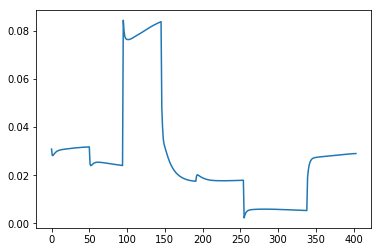

In [73]:
plt.plot([x for x in range(totalEpochs)], lossVals)
plt.savefig("loss_function.png")

In [48]:
def calcLoss(test_X_fName, test_y_fName):
    
    test, test_X, test_y = parseSheet(os.path.join("../Data", test_X_fName, "Data.csv"), os.path.join("OriVectUsers/", test_y_fName))
    
    test_X = test_X.view(-1, 1, test_X.shape[1]).float()
    print(test_X.shape)
    outputs = rnn(test_X)
    
    loss = error(outputs, test_y)
    
    print(loss)

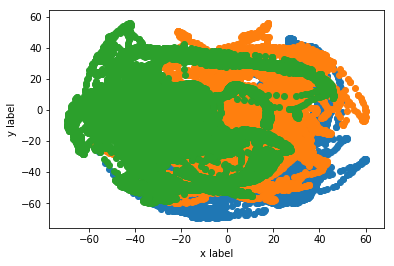

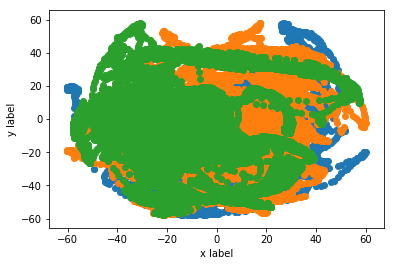

torch.Size([24821, 1, 6])
tensor(0.0768, grad_fn=<MseLossBackward>)


In [49]:
calcLoss(test_X_fName, test_y_fName)